In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#Read Toyota data
data_TM = pd.read_csv('/content/TM.csv')
data_TM

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,67.389999,67.900002,67.309998,67.779999,59.586105,377100
1,2012-01-04,68.230003,68.680000,68.070000,68.430000,60.157532,501600
2,2012-01-05,68.500000,68.830002,68.370003,68.620003,60.324562,343700
3,2012-01-06,68.519997,68.599998,68.220001,68.510002,60.227848,212000
4,2012-01-09,68.500000,68.709999,68.220001,68.419998,60.148735,301700
...,...,...,...,...,...,...,...
2997,2023-11-30,189.529999,190.000000,189.130005,189.779999,189.779999,189400
2998,2023-12-01,190.770004,192.809998,190.369995,192.740005,192.740005,237500
2999,2023-12-04,188.339996,189.110001,187.050003,187.369995,187.369995,331200
3000,2023-12-05,187.699997,188.979996,187.500000,187.990005,187.990005,199600


In [3]:
train_size = int(0.6 * len(data_TM))
test_size = int(0.2 * len(data_TM))
val_size = len(data_TM) - train_size - test_size

train_data = data_TM[:train_size]
test_data = data_TM[train_size:train_size+test_size]
val_data = data_TM[train_size+test_size:]

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.5 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6381.581, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6378.874, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6380.037, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6379.999, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6377.633, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6377.734, Time=1.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.833 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_val_pred =  model.predict(n_periods=len(y_val))

In [11]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data_TM.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[120.339996 120.339996 120.339996 120.339996 120.339996 120.339996
 120.339996 120.339996 120.339996 120.339996 120.339996 120.339996
 120.339996 120.339996 120.339996 120.339996 120.339996 120.339996
 120.339996 120.339996 120.339996 120.339996 120.339996 120.339996
 120.339996 120.339996 120.339996 120.339996 120.339996 120.339996]


In [12]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_pred, y_test)
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
test_mape = mean_absolute_percentage_error(y_pred, y_test)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_val_pred, y_val)
val_rmse = np.sqrt(mean_absolute_error(y_val_pred, y_val))
val_mape = mean_absolute_percentage_error(y_val_pred, y_val)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 17.508419865000004
Testing RMSE: 22.924561599544933
Testing MAPE: 0.14549127843580784
---------------------------
Validation MAE: 42.87000381031614
Validation RMSE: 6.547518904922394
Validation MAPE: 0.35624069499151506


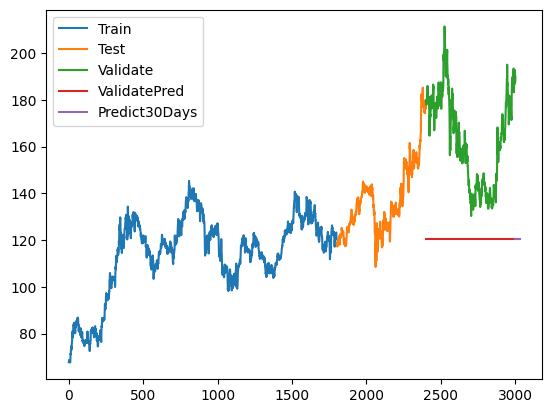

In [14]:
# Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()